In [2]:
import os
import math

import torch
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm, trange

from taskpriors import sampler

In [3]:
# List available kernel files
KERNEL_DIR = Path("./kernels_out")
kernel_files = list(KERNEL_DIR.glob("K_*.pt"))

if not kernel_files:
    print("No kernel files found in 'kernels_out' directory!")
    print("Please run generate_timm_kernels.ipynb first.")
else:
    print(f"Found {len(kernel_files)} kernel files:")
    for i, f in enumerate(kernel_files):
        model_name = f.stem.split('_', 1)[1].rsplit('_', 1)[0]
        n_images = int(f.stem.split('_')[-1])
        print(f"[{i}] {model_name} ({n_images} images)")

Found 27 kernel files:
[0] Salesforce__blip-itm-large-flickr (8192 images)
[1] Salesforce__blip-itm-base-coco (8192 images)
[2] openai__clip-vit-large-patch14 (8192 images)
[3] kakaobrain__align-base (8192 images)
[4] laion__CLIP-ViT-B-32-laion2B-s34B-b79K (8192 images)
[5] facebook__dinov2-small (8192 images)
[6] google__siglip-base-patch16-256-multilingual (8192 images)
[7] google__siglip-large-patch16-256 (8192 images)
[8] facebook__dinov2-large (8192 images)
[9] google__siglip-base-patch16-384 (8192 images)
[10] laion__CLIP-ViT-H-14-laion2B-s32B-b79K (8192 images)
[11] Salesforce__blip-image-captioning-large (8192 images)
[12] Salesforce__blip-itm-base-flickr (8192 images)
[13] google__siglip-large-patch16-384 (8192 images)
[14] Salesforce__blip-itm-large-coco (8192 images)
[15] facebook__dinov2-base (8192 images)
[16] openai__clip-vit-base-patch32 (8192 images)
[17] google__siglip-base-patch16-224 (8192 images)
[18] google__siglip-so400m-patch14-384 (8192 images)
[19] facebook__di

In [4]:
selected_kernel_idx = 18

selected_kernel = kernel_files[selected_kernel_idx].stem

In [5]:
# Load the selected kernel
selected_kernel_file = KERNEL_DIR / f"{selected_kernel}.pt"
kernel_data = torch.load(selected_kernel_file)

K = kernel_data['K'].numpy()
Z = kernel_data['Z'].numpy()
indices = kernel_data['indices']
feat_dim = kernel_data['dim']

print(f"Loaded kernel: {selected_kernel}")
print(f"Kernel shape: {K.shape}")
print(f"Original feature dimension: {feat_dim}")

Loaded kernel: K_google__siglip-so400m-patch14-384_8192
Kernel shape: (8192, 8192)
Original feature dimension: 1152


In [6]:
# Apply t-SNE for visualization
print("Computing t-SNE embedding...")
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(Z)
print("t-SNE completed.")

Computing t-SNE embedding...


t-SNE completed.


In [7]:
# Center the kernel matrix K
n = K.shape[0]
one_n = np.ones((n, n)) / n
K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:02<00:00,  4.24it/s]


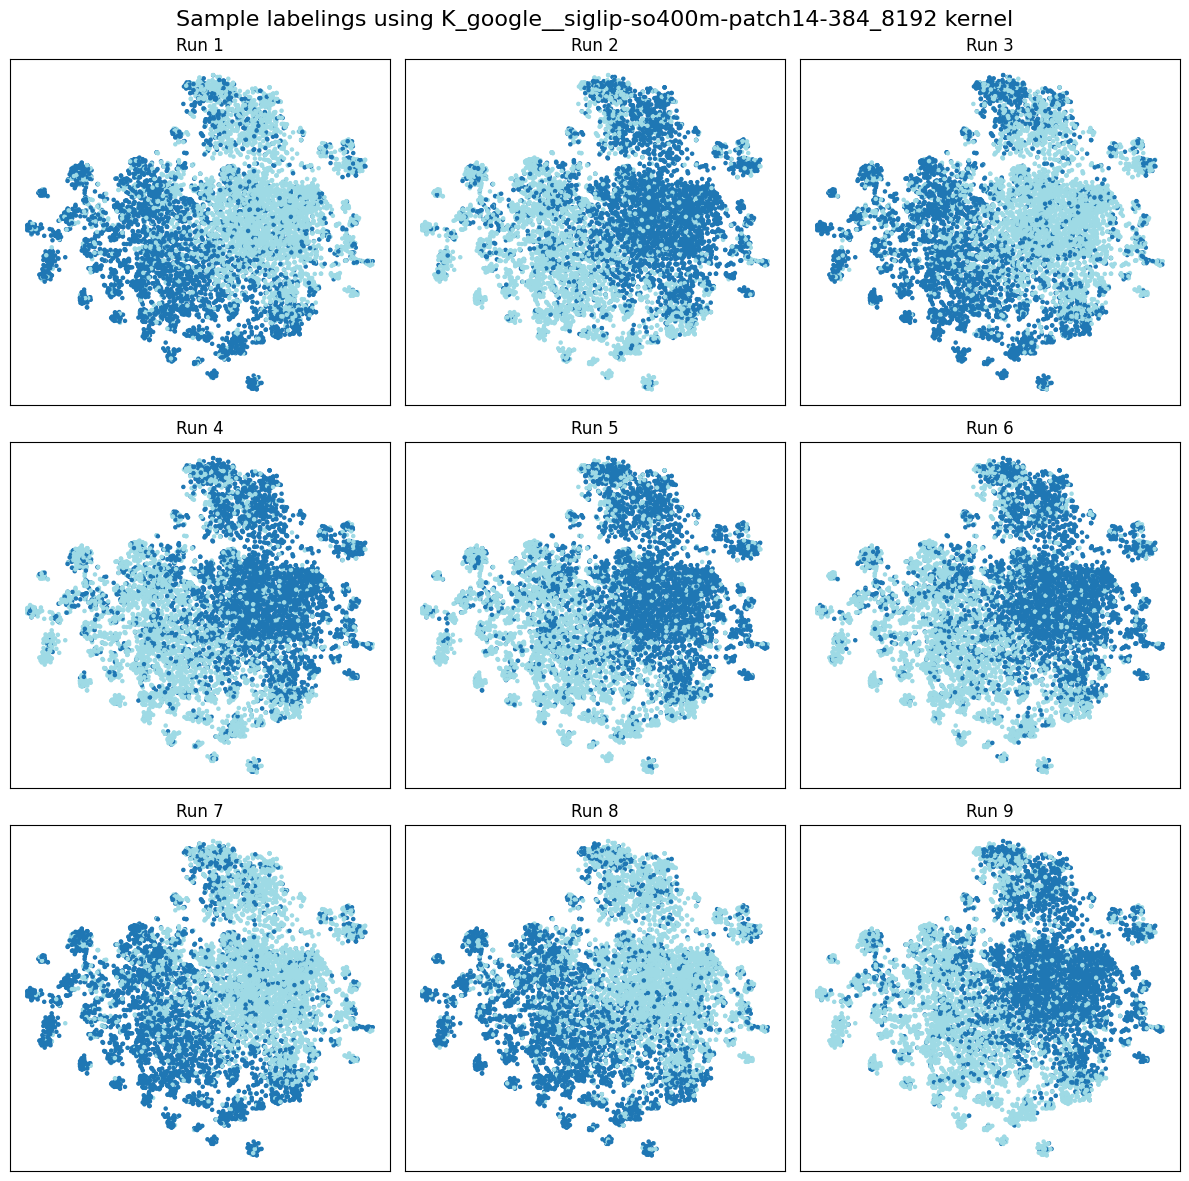

In [16]:
# Generate and visualize a sample of labelings
n_samples = 9
cols = 3
rows = math.ceil(n_samples / cols)

n_classes = 2 # Number of classes
temp = 500 # Sampling temperature

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), tight_layout=True)
axes = axes.flatten()
sample_labels_list = []

for i in trange(n_samples):
    # Generate labels
    labels = sampler.sample_labels_from_kernel(K_centered, num_classes=n_classes, temperature=temp, seed=i)
    sample_labels_list.append(labels)
    
    # Plot
    ax = axes[i]
    scatter = ax.scatter(emb_2d[:, 0], emb_2d[:, 1],
               c=labels, cmap="tab20", s=5, alpha=1)
    ax.set_title(f"Run {i+1}")
    ax.set_xticks([])
    ax.set_yticks([])

# Hide any extra axes
for ax in axes[n_samples:]:
    ax.axis("off")

plt.suptitle(f"Sample labelings using {selected_kernel} kernel", fontsize=16)
plt.show()

In [17]:
# Generate a larger set of labelings to save and evaluate

n_runs = 512  # Number of different labelings to generate
labels_list = []

for i in trange(n_runs):
    labels_run = sampler.sample_labels_from_kernel(K_centered, num_classes=n_classes, temperature=temp, seed=i)
    labels_list.append(labels_run)

# Convert to numpy array and save
labels_array = np.array(labels_list)
print(f"Generated labels shape: {labels_array.shape}")

# Ensure output directory exists
output_dir = "labels_out"
os.makedirs(output_dir, exist_ok=True)

# Extract model name for the filename
output_file = os.path.join(output_dir, f"labels_mini_imagenet_{selected_kernel}.npy")

np.save(output_file, labels_array)
print(f"Saved labels to {output_file}")

100%|██████████| 512/512 [02:01<00:00,  4.22it/s]

Generated labels shape: (512, 8192)
Saved labels to labels_out/labels_mini_imagenet_K_google__siglip-so400m-patch14-384_8192.npy
